##### Convolutional Neural Networks

Since these are larger (32x32x3) images, it may prove useful to speed up your training time by using a GPU. CUDA is a parallel computing platform and CUDA Tensors are the same as typical Tensors, only they utilize GPU's for computation.

In [2]:
import torch
import numpy as np

# # check if CUDA is available
# train_on_gpu = torch.cuda.is_available()

# if not train_on_gpu:
#     print('CUDA is not available.  Training on CPU ...')
# else:
#     print('CUDA is available!  Training on GPU ...')

# Determine the best available device
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('CUDA is available! Using GPU...')
elif torch.backends.mps.is_available():
    device = torch.device('mps')  # Apple Metal (M1/M2 chips)
    print('MPS is available! Using Apple GPU...')
else:
    device = torch.device('cpu')
    print('No GPU available, using CPU...')



MPS is available! Using Apple GPU...


---
## Load the [Data](http://pytorch.org/docs/stable/torchvision/datasets.html)

Downloading may take a minute. We load in the training and test data, split the training data into a training and validation set, then create DataLoaders for each of these sets of data.

In [6]:
import torchvision.transforms
import multiprocessing
from helpers import get_train_val_data_loaders, get_test_data_loader

"""
PyTorch Packages Comparison: torch vs torchvision

torch (PyTorch Core):
    - Primary package for deep learning
    - Core Features:
        • Tensor operations (CPU/GPU/MPS)
        • Neural network building blocks (nn.Module, layers)
        • Automatic differentiation (autograd)
        • Optimizers (SGD, Adam, etc.)
        • Basic data utilities (Dataset, DataLoader)
    - Usage:
        import torch
        import torch.nn as nn
        import torch.optim as optim

torchvision:
    - Computer vision extension for PyTorch
    - Key Features:
        • Prepackaged datasets (CIFAR10, ImageNet, etc.)
        • Image transformations (transforms module)
        • Pretrained vision models (ResNet, VGG, etc.)
        • Image/video utilities
    - Usage: 
        import torchvision
        import torchvision.datasets as datasets
        import torchvision.transforms as transforms

Relationship:
    - torchvision builds on torch's core functionality
    - torch provides the engine, torchvision provides vision-specific tools
    - Always need torch installed to use torchvision

Example Integration:
    # torch for model building
    model = torch.nn.Sequential(
        torch.nn.Linear(784, 256),
        torch.nn.ReLU()
    )
    
    # torchvision for data
    transform = transforms.Compose([
        transforms.ToTensor()
    ])
    data = datasets.CIFAR10('./data', transform=transform)
"""

# number of subprocesses to use for data loading
num_workers = multiprocessing.cpu_count()
# how many samples per batch to load
batch_size = 20
# percentage of training set to use as validation
valid_size = 0.2

# convert data to a normalized torch.FloatTensor
transforms = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

# If you want to refresh how to load and split data in pytorch, open the helpers.py file
# and read the code. We have documented it with comments so you can follow along easily
train_dl, valid_dl = get_train_val_data_loaders(batch_size, valid_size, transforms, num_workers)
test_dl = get_test_data_loader(batch_size, transforms, num_workers)

# For convenience let's group them together in a dictionary
data_loaders = {
    'train': train_dl,
    'valid': valid_dl,
    'test': test_dl
}

100%|██████████| 170498071/170498071 [02:43<00:00, 1045988.70it/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


In [7]:
# specify the image classes
classes = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]

### Visualize a Batch of Training Data

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img, sub):
    img = img / 2 + 0.5  # unnormalize
    sub.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image
    sub.axis("off")

In [11]:
# obtain one batch of training images
dataiter = iter(data_loaders['train'])
images, labels = next(dataiter)
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
# display 20 images
fig, subs = plt.subplots(2, 10, figsize=(25, 4))

for i, sub in enumerate(subs.flatten()):
    imshow(images[i], sub)
    sub.set_title(classes[labels[i]])

### View an Image in More Detail

Here, we look at the normalized red, green, and blue (RGB) color channels as three separate, grayscale intensity images.

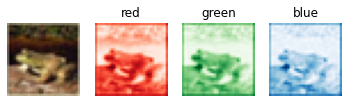

In [ ]:
"""
Visualizes an RGB image and its individual color channels.

Purpose:
    Displays a composite RGB image alongside its separate red, green, and blue 
    channels to demonstrate how color images are constructed from channels.

Parameters (implied from context):
    images: A batch of images where each image has shape (3, H, W) for RGB channels
    index: Index 3 selects the 4th image from the batch (0-based indexing)

Workflow:
    1. Extracts one RGB image from batch and removes singleton dimensions
    2. Creates 4 subplots: composite + individual channels
    3. Applies appropriate colormaps to each channel visualization
    4. Displays with titles and clean formatting

Key Functions/Methods:
    - np.squeeze(): Removes single-dimensional entries
    - plt.subplots(): Creates figure and subplot grid
    - imshow(): Displays image data (custom or matplotlib's)

Example Usage:
    # Assuming 'images' is a batch of CIFAR-10 images
    visualize_rgb_channels(images, index=3)

Output:
    A 1x4 grid showing:
    - Left: Original RGB image
    - Middle 3: Red, Green, Blue channels separately

Notes:
    - Channels assumed to be in RGB order (index 0: R, 1: G, 2: B)
    - First subplot uses a custom 'imshow' function (likely handles normalization)
    - Subsequent subplots use matplotlib's imshow with channel-specific colormaps
    - 'Reds', 'Greens', 'Blues' colormaps highlight intensity per channel
"""

# The actual code for documentation:
rgb_img = np.squeeze(images[3])  # Remove batch dimension from 4th image
channels = ['composite', 'red', 'green', 'blue']
cmaps = [None, 'Reds', 'Greens', 'Blues']

fig, subs = plt.subplots(1, 4)  # Create 1x4 subplot grid

for i, sub in enumerate(subs.flatten()):
    if i == 0:
        imshow(rgb_img, sub)  # Custom display for composite image
    else:
        img = rgb_img[i-1]  # Get individual channel (R, G, or B)
        sub.imshow(img, cmap=cmaps[i])  # Show with channel-appropriate colormap
        sub.set_title(channels[i])
        sub.axis("off")

---
## Define the Network [Architecture](http://pytorch.org/docs/stable/nn.html)

This time, you'll define a CNN architecture. Instead of an MLP, which used linear, fully-connected layers, you'll use the following:
* [Convolutional layers](https://pytorch.org/docs/stable/nn.html#conv2d), which can be thought of as stack of filtered images.
* [Maxpooling layers](https://pytorch.org/docs/stable/nn.html#maxpool2d), which reduce the x-y size of an input, keeping only the most _active_ pixels from the previous layer.
* The usual Linear + Dropout layers to avoid overfitting and produce a 10-dim output.


```mermaid
flowchart TD
    Input["Input Image<br>3×32×32"] --> Conv1["Conv2d Layer 1<br>3→16 channels<br>3×3 kernel, padding=1<br>Output: 16×32×32"]
    Conv1 --> ReLU1["ReLU Activation 1"]
    ReLU1 --> Pool1["MaxPool2d 1<br>2×2, stride=2<br>Output: 16×16×16"]
    
    Pool1 --> Conv2["Conv2d Layer 2<br>16→32 channels<br>3×3 kernel, padding=1<br>Output: 32×16×16"]
    Conv2 --> ReLU2["ReLU Activation 2"]
    ReLU2 --> Pool2["MaxPool2d 2<br>2×2, stride=2<br>Output: 32×8×8"]
    
    Pool2 --> Conv3["Conv2d Layer 3<br>32→64 channels<br>3×3 kernel, padding=1<br>Output: 64×8×8"]
    Conv3 --> ReLU3["ReLU Activation 3"]
    ReLU3 --> Pool3["MaxPool2d 3<br>2×2, stride=2<br>Output: 64×4×4"]
    
    Pool3 --> Flatten["Flatten<br>Output: 1024<br>(64×4×4)"]
    Flatten --> FC1["Fully Connected 1<br>1024 (64×16)→500 neurons"]
    FC1 --> Dropout["Dropout<br>p=0.5"]
    Dropout --> ReLUFC["ReLU Activation"]
    ReLUFC --> FC2["Fully Connected 2<br>500→n_classes neurons"]
    FC2 --> Output["Output<br>(Class Probabilities)"]
    
    style Input fill:#BCFB89,stroke:#333,stroke-width:2px,color:black
    style Conv1 fill:#FBF266,stroke:#333,stroke-width:2px,color:black
    style ReLU1 fill:#FA756A,stroke:#333,stroke-width:2px,color:black
    style Pool1 fill:#9AE4F5,stroke:#333,stroke-width:2px,color:black
    style Conv2 fill:#FBF266,stroke:#333,stroke-width:2px,color:black
    style ReLU2 fill:#FA756A,stroke:#333,stroke-width:2px,color:black
    style Pool2 fill:#9AE4F5,stroke:#333,stroke-width:2px,color:black
    style Conv3 fill:#FBF266,stroke:#333,stroke-width:2px,color:black
    style ReLU3 fill:#FA756A,stroke:#333,stroke-width:2px,color:black
    style Pool3 fill:#9AE4F5,stroke:#333,stroke-width:2px,color:black
    style Flatten fill:#FCEB14,stroke:#333,stroke-width:2px,color:black
    style FC1 fill:#0096D9,stroke:#333,stroke-width:2px,color:black
    style Dropout fill:#FE9237,stroke:#333,stroke-width:2px,color:black
    style ReLUFC fill:#FA756A,stroke:#333,stroke-width:2px,color:black
    style FC2 fill:#0096D9,stroke:#333,stroke-width:2px,color:black
    style Output fill:#BCFB89,stroke:#333,stroke-width:2px,color:black
```

#### TODO: Define a model with multiple convolutional layers, and define the feedforward metwork behavior.

The more convolutional layers you include, the more complex patterns in color and shape a model can detect. It's suggested that your final model include 2 or 3 convolutional layers as well as linear layers + dropout in between to avoid overfitting. 

It's good practice to look at existing research and implementations of related models as a starting point for defining your own models. You may find it useful to look at [this PyTorch classification example](https://github.com/pytorch/tutorials/blob/master/beginner_source/blitz/cifar10_tutorial.py) to help decide on a final structure.

#### Output volume for a convolutional layer

To compute the output size of a given convolutional layer we can perform the following calculation (taken from [Stanford's cs231n course](http://cs231n.github.io/convolutional-networks/#layers)):
> We can compute the spatial size of the output volume as a function of the input volume size (W), the kernel/filter size (F), the stride with which they are applied (S), and the amount of zero padding used (P) on the border. The correct formula for calculating how many neurons define the output_W is given by `(W−F+2P)/S+1`. 



#### Computing Output Dimensions in Convolutional Neural Networks

For a 7x7 input and a 3x3 filter with stride 1 and pad 0 we would get a 5x5 output. With stride 2 we would get a 3x3 output. The dimensional transformation that occurs when applying a convolutional filter to an input feature map follows precise mathematical rules. Let me explain why a 7×7 input processed with a 3×3 filter yields different output dimensions depending on stride and padding values.

For any convolutional operation, the output dimensions can be calculated using the following formula:

$$\text{Output Size} = \left\lfloor\frac{n + 2p - k}{s} + 1\right\rfloor$$

Where:
- $n$ is the input dimension size (7 in this example)
- $p$ is the padding (0 in the first case)
- $k$ is the kernel/filter size (3 in this example)
- $s$ is the stride (1 or 2 in the examples)
- $\lfloor \cdot \rfloor$ represents the floor function (rounding down to the nearest integer)

Let's apply this formula to the specific cases mentioned:

**Case 1: 7×7 input, 3×3 filter, stride 1, padding 0**

$$\text{Output Size} = \left\lfloor\frac{7 + 2(0) - 3}{1} + 1\right\rfloor = \left\lfloor\frac{4}{1} + 1\right\rfloor = 5$$

This yields a 5×5 output. Conceptually, this can be visualized by sliding the 3×3 filter across the 7×7 input. With no padding and stride 1, the filter can only be positioned in 5 different horizontal positions and 5 different vertical positions without extending beyond the input boundaries.

**Case 2: 7×7 input, 3×3 filter, stride 2, padding 0**

$$\text{Output Size} = \left\lfloor\frac{7 + 2(0) - 3}{2} + 1\right\rfloor = \left\lfloor\frac{4}{2} + 1\right\rfloor = \left\lfloor 2 + 1 \right\rfloor = 3$$

With stride 2, the filter moves 2 pixels at a time, so it can only be positioned in 3 different positions both horizontally and vertically without exceeding the input boundaries. This results in a 3×3 output.

The geometric interpretation is straightforward: the 3×3 filter must fit entirely within the 7×7 input. With stride 1, the filter moves one pixel at a time, allowing it to occupy positions (0,0), (0,1), (0,2), (0,3), (0,4) along the first row, and similarly for subsequent rows, resulting in 5×5 = 25 total positions. With stride 2, the filter positions are (0,0), (0,2), (0,4), (2,0), etc., which yields 3×3 = 9 total positions.

This dimensional reduction is a fundamental property of convolutional layers and explains why deeper networks with multiple convolutional layers progressively reduce the spatial dimensions of feature maps, especially when using strides greater than 1 or when not employing padding. Understanding these dimension calculations is essential for designing neural network architectures, as it ensures proper tensor shape compatibility between consecutive layers.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
# class Net(nn.Module):
#     def __init__(self, n_classes=10):

#         super(Net, self).__init__()

#         # convolutional layer 1. It sees 3x32x32 image tensor
#         # and produces 16 feature maps 32x32 (i.e., a tensor 16x32x32)
#         self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
#         self.relu1 = nn.ReLU()
#         # 2x2 pooling with stride 2. It sees tensors 16x32x32
#         # and halves their size, i.e., the output will be 16x16x16
#         self.pool1 = nn.MaxPool2d(2, 2)

#         # convolutional layer (sees the output of the prev layer, i.e.,
#         # 16x16x16 tensor)
#         self.conv2 = nn.Conv2d(16, 32, 3, padding=1)  # -> 32x16x16
#         self.relu2 = nn.ReLU()
#         self.pool2 = nn.MaxPool2d(2, 2)  # -> 32x8x8

#         # convolutional layer
#         self.conv3 = nn.Conv2d(32, 64, 3, padding=1)  # -> 64x8x8
#         self.relu3 = nn.ReLU()
#         self.pool3 = nn.MaxPool2d(2, 2)  # -> 64x4x4

#         # linear layer (64 * 4 * 4 -> 500)
#         self.flatten = nn.Flatten()
#         self.fc1 = nn.Linear(64 * 4 * 4, 500)
#         self.dp1 = nn.Dropout(0.5)
#         self.rl1 = nn.ReLU()

#         # linear layer (500 -> 10)
#         self.fc2 = nn.Linear(500, n_classes)

#     def forward(self, x):

#         x = self.relu1(self.pool1(self.conv1(x)))
#         x = self.relu2(self.pool2(self.conv2(x)))
#         x = self.relu3(self.pool3(self.conv3(x)))

#         x = self.flatten(x)

#         x = self.rl1(self.dp1(self.fc1(x)))

#         x = self.fc2(x)

#         return x


# We can also use nn.Sequential, which makes things a lot easier
class Net(nn.Module):
    """
        Feature Map Size Calculation for CIFAR-10 CNN

        Calculates the final feature map dimensions (4x4) before flattening in a 3-layer CNN.

        Network Architecture:
            Input: 3x32x32 (CIFAR-10 RGB images)
            Layer Progression:
                1. Conv1 (3→16 channels, kernel=3, padding=1) + ReLU → 16x32x32
                2. MaxPool1 (2x2, stride=2) → 16x16x16
                3. Conv2 (16→32 channels, kernel=3, padding=1) + ReLU → 32x16x16
                4. MaxPool2 (2x2, stride=2) → 32x8x8
                5. Conv3 (32→64 channels, kernel=3, padding=1) + ReLU → 64x8x8
                6. MaxPool3 (2x2, stride=2) → 64x4x4 (final feature maps)

        Key Formula:
            For each MaxPool2d(2,2) layer:
                Output size = Input size / 2
            (applies to both height and width)

        Final Feature Dimensions:
            - Channels: 64 (from last Conv3 layer)
            - Spatial: 4x4 (from 3 pooling layers: 32→16→8→4)

        Usage in Network:
            self.fc1 = nn.Linear(64 * 4 * 4, 500)  # 1024 → 500
            # Where 64*4*4 = 1024 elements after flattening

        Visualization:
            Input (32) → Pool1 → 16 → Pool2 → 8 → Pool3 → 4
            (applies equally to both width and height)


        Final Convolutional Layer Output Interpretation:

        Dimensions: 64×4×4 breakdown:
        - 64: Number of output channels/kernels/feature maps
        (Each kernel learns to detect different patterns/features)
        
        - 4×4: Spatial dimensions (width × height) of each feature map
        (Represents how much the original 32×32 input has been downsampled)

        Visualization:
            ┌───────────────────────┐
            │ 64 Feature Maps       │
            │                       │
            │   ┌───┐ ┌───┐ ...     │
            │   │4×4│ │4×4│         │
            │   └───┘ └───┘         │
            │                       │
            └───────────────────────┘

        Key Points:
        1. Each of the 64 kernels produces one 4×4 feature map
        2. The 4×4 size shows the remaining spatial information after:
        - 3 convolutional layers (preserve spatial size with padding=1)
        - 3 max-pooling layers (each halves the spatial dimensions)
        3. These 64×4×4=1024 values will be flattened before feeding to FC layers    
    """
    def __init__(self, n_classes=10):

        super(Net, self).__init__()

        self.model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, 3, padding=1),  # -> 32x16x16
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # -> 32x8x8
            nn.Conv2d(32, 64, 3, padding=1),  # -> 64x8x8
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # -> 64x4x4
            nn.Flatten(),  # -> 1x64x4x4
            nn.Linear(64 * 4 * 4, 500),  # -> 500
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(500, n_classes),
        )

    def forward(self, x):

        return self.model(x)


# create a complete CNN
model = Net()
print(model)

# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

Net(
  (model): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=1024, out_features=500, bias=True)
    (11): Dropout(p=0.5, inplace=False)
    (12): ReLU()
    (13): Linear(in_features=500, out_features=10, bias=True)
  )
)


## How many parameters?

Now that you built the network, can you compute with pen and paper how many parameters does your network have? Does your answer match the output of the following cell?

In [9]:
# (16*3*3*3 + 16) + (32 * 3 * 3 * 16 + 32) + (64 * 3 * 3 * 32 + 64) + ((64 *4 *4 + 1) * 500) + (501 * 10)

sum(p.numel() for p in model.parameters() if p.requires_grad)

541094

## Visualize your network (optional)

You can visualize your achitecture by using netron.app. Just execute the following cell (which will save the network to a file called "cifar10_network.pt" in this directory), then download the produced `cifar10_network.pt` to your computer. Finally, go to [Netron.app](https://netron.app) and click on `Open Model`, and select the file you just downloaded.

In [10]:
scripted = torch.jit.script(model)
torch.jit.save(scripted, "cifar10_network.pt")

### Specify [Loss Function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [Optimizer](http://pytorch.org/docs/stable/optim.html)

Decide on a loss and optimization function that is best suited for this classification task. The linked code examples from above, may be a good starting point; [this PyTorch classification example](https://github.com/pytorch/tutorials/blob/master/beginner_source/blitz/cifar10_tutorial.py). Pay close attention to the value for **learning rate** as this value determines how your model converges to a small error.

#### TODO: Define the loss and optimizer and see how these choices change the loss over time.

In [11]:
import torch.optim as optim

# specify loss function (categorical cross-entropy)
loss = nn.CrossEntropyLoss()

# specify optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01)

---
## Train the Network

Remember to look at how the training and validation loss decreases over time; if the validation loss ever increases it indicates possible overfitting. (In fact, in the below example, we could have stopped around epoch 33 or so!)

In [12]:
from helpers import optimize

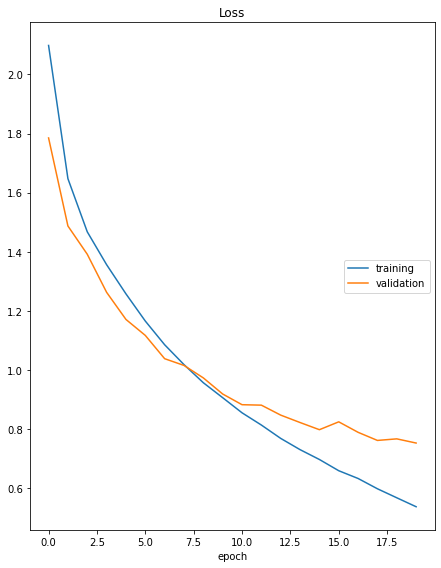

Loss
	training         	 (min:    0.538, max:    2.098, cur:    0.538)
	validation       	 (min:    0.753, max:    1.785, cur:    0.753)


In [13]:
optimize(
    data_loaders,
    model,
    optimizer,
    loss,
    20,
    "cifar10_best_valid.pt",
    interactive_tracking=True
)

###  Load the Model with the Lowest Validation Loss

In [14]:
model.load_state_dict(torch.load('cifar10_best_valid.pt'))

<All keys matched successfully>

---
## Test the Trained Network

Test your trained model on previously unseen data! A "good" result will be a CNN that gets around 70% (or more, try your best!) accuracy on these test images.

In [15]:
from helpers import one_epoch_test

In [16]:
test_loss, preds, actuals = one_epoch_test(data_loaders['valid'], model, loss)

Testing: 100%|███████████████████████████████| 500/500 [00:03<00:00, 153.56it/s]

Test Loss: 0.752981


Test Accuracy: 74% (7414/10000)


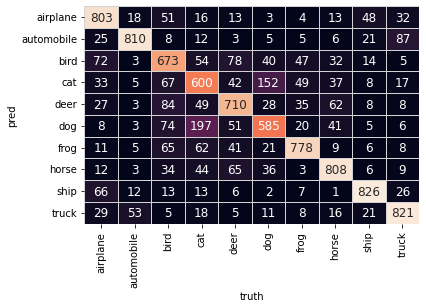

In [17]:
from helpers import plot_confusion_matrix

cm = plot_confusion_matrix(preds, actuals, classes)

In [18]:
print("Accuracy by class:\n")
for i, col in enumerate(cm):
    print(f"    {col:11s}: {cm[col][i] / cm[col].sum():.2f}")

Accuracy by class:

    airplane   : 0.74
    automobile : 0.89
    bird       : 0.63
    cat        : 0.56
    deer       : 0.70
    dog        : 0.66
    frog       : 0.81
    horse      : 0.79
    ship       : 0.86
    truck      : 0.81


### Question: What are your model's weaknesses and how might they be improved?

**Answer**: This model seems to do best on vehicles rather than animals. For example, it does best on the automobile class and worst on the cat class. I suspect it's because animals vary in color and size and so it would improve this model if I could increase the number of animal images in the first place or perhaps if I added another convolutional layer to detect finer patterns in these images. I could also experiment with a smaller learning rate so that the model takes small steps in the right direction as it is training.

_NOTE_: we will see how to improve the performances even further with simple things like data augmentation and batch norm

### Visualize Sample Test Results

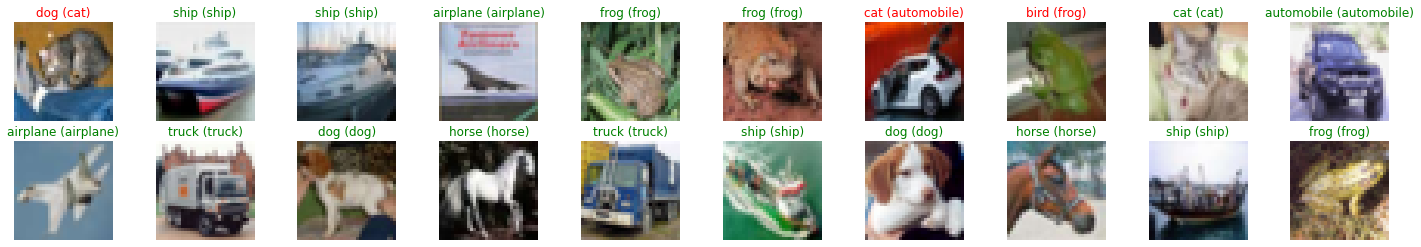

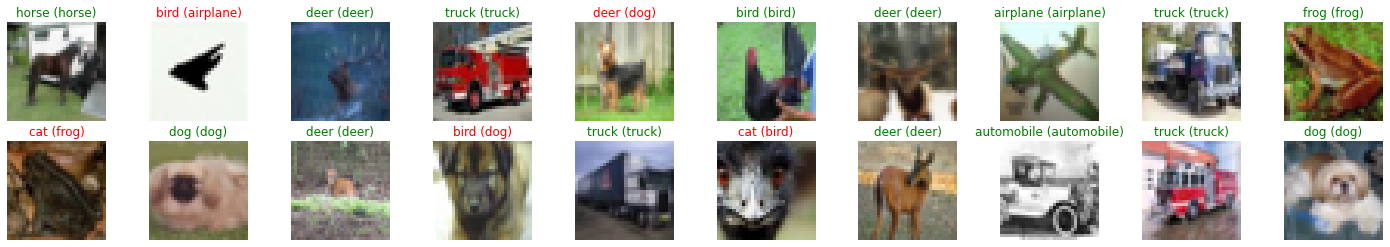

In [19]:
# obtain one batch of test images
dataiter = iter(data_loaders['test'])

for i in range(2):
    images, labels = dataiter.next()
    images.numpy()

    # move model inputs to cuda, if GPU available
    if train_on_gpu:
        images = images.cuda()

    # get sample outputs
    output = model(images)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

    # plot the images in the batch, along with predicted and true labels
    fig, subs = plt.subplots(2, 10, figsize=(25, 4))
    for i, ax in enumerate(subs.flatten()):
        imshow(images[i].cpu().numpy(), ax)
        ax.set_title("{} ({})".format(classes[preds[i]], classes[labels[i]]),
                     color=("green" if preds[i]==labels[i].item() else "red"))
        ax.axis("off")